In [ ]:
import os
import gc
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense, ELU, BatchNormalization
from keras.utils import to_categorical # np_utils
from keras import initializers
# from keras.losses import SparseCategoricalCrossentropy


from keras.datasets import reuters

print(os.getcwd())
print("Modules imported \n")

/content
Modules imported 



# Data ingestion

In [ ]:
NUM_WORDS=12_000

In [ ]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=NUM_WORDS)

2110848/2110848 [==============================] - 0s 0us/step


In [ ]:
print("train_data ", train_data.shape)
print("train_labels ", train_labels.shape)

print("test_data ", test_data.shape)
print("test_labels ", test_labels.shape)

train_data  (8982,)
train_labels  (8982,)
test_data  (2246,)
test_labels  (2246,)


# Inspection of article and it's label

In [ ]:
# Reverse dictionary to see words instead of integers
# Note that the indices are offset by 3 because 0, 1, and 2 are reserved indices for “padding,” “start of sequence,” and “unknown.”

article_num = 207

word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[article_num]])
def decoded_news(article_number):
  decoded_article = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[article_number]])
  return decoded_article

decoded_labels = reuters.get_label_names()
print(decoded_news(article_num), "\n")
print(train_labels[article_num])
print(decoded_labels[train_labels[article_num]])

550378/550378 [==============================] - 0s 0us/step
? the u s agriculture department's report on export markets for u s grain ? for release today has been delayed until wednesday april 1 a department spokeswoman said no reason was given for the delay in releasing the monthly report reuter 3 

1
grain


In [ ]:
print(decoded_labels)

('cocoa', 'grain', 'veg-oil', 'earn', 'acq', 'wheat', 'copper', 'housing', 'money-supply', 'coffee', 'sugar', 'trade', 'reserves', 'ship', 'cotton', 'carcass', 'crude', 'nat-gas', 'cpi', 'money-fx', 'interest', 'gnp', 'meal-feed', 'alum', 'oilseed', 'gold', 'tin', 'strategic-metal', 'livestock', 'retail', 'ipi', 'iron-steel', 'rubber', 'heat', 'jobs', 'lei', 'bop', 'zinc', 'orange', 'pet-chem', 'dlr', 'gas', 'silver', 'wpi', 'hog', 'lead')


In [ ]:
# VECTORIZE function

def vectorize_sequences(sequences, dimension=NUM_WORDS):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [ ]:
# Vectorize and Normalize train and test to tensors with 10k columns

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

print("x_train ", x_train.shape)
print("x_test ", x_test.shape)

x_train  (8982, 12000)
x_test  (2246, 12000)


### First dimension of shape preserved between loaded and vectorized data


In [ ]:
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

print("one_hot_train_labels ", one_hot_train_labels.shape)
print("one_hot_test_labels ", one_hot_test_labels.shape)


one_hot_train_labels  (8982, 46)
one_hot_test_labels  (2246, 46)


### Balancing classes in this dataset is not feasible as it cannot be done on unvectorized data and trying to balance the vectorized data for 46 classes results in memory usage going through the roof

In [ ]:
# from imblearn.over_sampling import SMOTE
# oversample = SMOTE()
# x_train, one_hot_train_labels = oversample.fit_resample(x_train, one_hot_train_labels)

In [ ]:
print("train labels sample", one_hot_train_labels[123,:])

train labels sample [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# x_val = x_train[:1000]
# partial_x_train = x_train[1000:]
# y_val = one_hot_train_labels[:1000]
# partial_y_train = one_hot_train_labels[1000:]

from sklearn.model_selection import train_test_split
partial_x_train, x_val, partial_y_train, y_val = train_test_split(x_train, one_hot_train_labels, test_size=0.115, random_state=42)

print("x_val ", x_val.shape)
print("y_val ", y_val.shape)

print("partial_x_train ", partial_x_train.shape)
print("partial_y_train ", partial_y_train.shape)

x_val  (1033, 12000)
y_val  (1033, 46)
partial_x_train  (7949, 12000)
partial_y_train  (7949, 46)


# Datasets label distribution plot

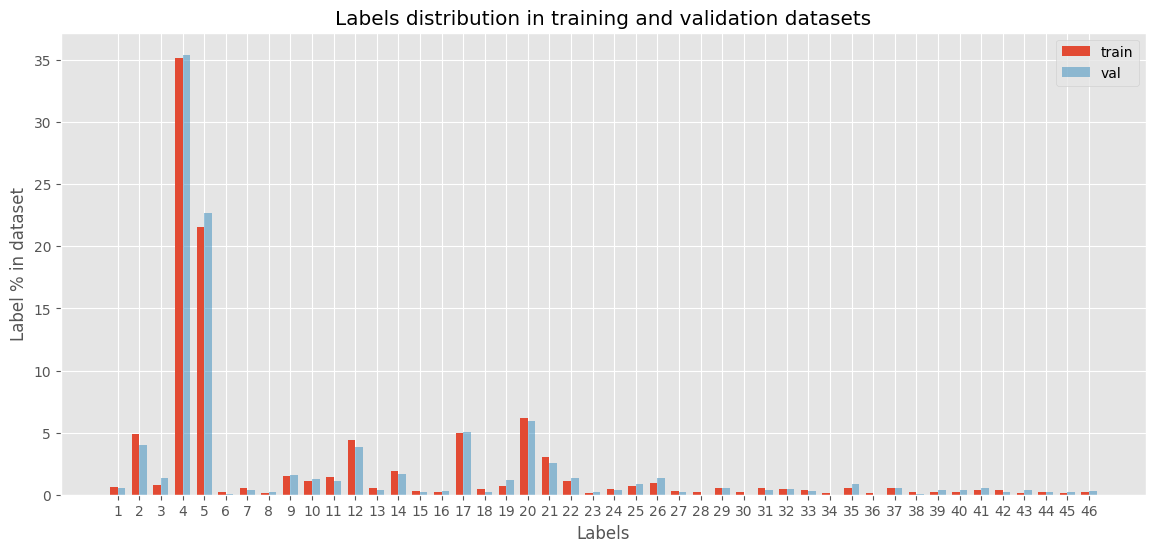

In [ ]:

# Divide column-wise sum by the number of rows
training_dist = np.sum(partial_y_train, axis=0) / partial_y_train.shape[0] * 100
val_dist = np.sum(y_val, axis=0) / y_val.shape[0] * 100
# Create bar plot
plt.figure(figsize=(14, 6))  # Adjust the figure size if needed
bar_width = 0.35
plt.bar(np.arange(len(training_dist)), training_dist, width=bar_width, label="train")
plt.bar(np.arange(len(val_dist))+bar_width, val_dist, alpha=0.5, width=bar_width, label="val")
plt.xlabel('Labels')
plt.ylabel('Label % in dataset')
plt.title('Labels distribution in training and validation datasets')
plt.legend()
plt.xticks(np.arange(len(training_dist)) + bar_width / 2, np.arange(len(training_dist)) + 1)
plt.show()

### Whether the validation and training datasets were hard-split or split using the function from sklearn the distribution in both cases is preserved

In [ ]:
# Calculate label distributions
def get_label_distribution(y):
    unique, counts = np.unique(y, return_counts=True)
    return dict(zip(unique, counts))

train_label_distribution = get_label_distribution(partial_y_train)
val_label_distribution = get_label_distribution(y_val)

# Display label distributions
print("Training label distribution:", train_label_distribution)
print("Validation label distribution:", val_label_distribution)

# Check for stratification equality
stratification_equal = all(train_label_distribution[label] / len(partial_y_train) == val_label_distribution[label] / len(y_val)
                          for label in train_label_distribution.keys())

if stratification_equal:
    print("Stratification is equal between training and validation datasets.")
else:
    print("Stratification differs between training and validation datasets.")

Training label distribution: {0.0: 357705, 1.0: 7949}
Validation label distribution: {0.0: 46485, 1.0: 1033}
Stratification is equal between training and validation datasets.


In [ ]:
# Calculate statistical properties for arr1
mean_arr1 = np.mean(training_dist)
variance_arr1 = np.var(training_dist)

# Calculate statistical properties for arr2
mean_arr2 = np.mean(val_dist)
variance_arr2 = np.var(val_dist)

# Compare statistical properties
mean_equal = np.isclose(mean_arr1, mean_arr2)
variance_equal = np.isclose(variance_arr1, variance_arr2)

print("Mean Equal:", mean_equal, mean_arr1, mean_arr2)
print("Variance Equal:", variance_equal, variance_arr1, variance_arr2)

Mean Equal: True 2.1739128 2.173913
Variance Equal: False 35.0976 36.256184


# Model

In [ ]:
model = models.Sequential()
model.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.001), \
                       activation='elu', input_shape=(NUM_WORDS,), kernel_initializer=tf.keras.initializers.HeNormal()))
# model.add(layers.Dropout(0.4))
# model.add(BatchNormalization())
model.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.001), \
                       activation='elu', kernel_initializer=tf.keras.initializers.HeNormal()))
# model.add(layers.Dropout(0.2))
# model.add(BatchNormalization())
model.add(layers.Dense(128, kernel_regularizer=regularizers.l1(0.001), activation='elu', kernel_initializer=tf.keras.initializers.HeNormal()))
model.add(layers.Dense(46, activation='softmax'))
model.summary()


"""
Also tried:
- adding more layers
- changing activation functions in hidden layers
- no kernel initializer
- more and neurons in each layer
- batch normalization
- dropout

Settled on this design although it's probably not the best performing but lightweight

"""

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               6144512   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 46)                5934      
                                                                 
Total params: 6314670 (24.09 MB)
Trainable params: 6314670 (24.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


"\nAlso tried:\n- adding more layers\n- changing activation functions in hidden layers\n- no kernel initializer\n- more and neurons in each layer\n- batch normalization\n- dropout \n\nSettled on this design although it's probably not the best performing but lightweight\n\n"

# Model training

In [ ]:
NumEpochs = 10 # 40 # 60 gave signs of overfitting
BatchSize = 512 # tried different batchsizes based on first layer input

model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy']) # RMSProp gave similar results
# sparse_caterogical_crossentropy didn't work because of the labels data being
# encoded by one-hot encoder: https://tinyurl.com/SparseCaterogicalCrossEntropy
history = model.fit(partial_x_train, partial_y_train, epochs=NumEpochs, batch_size=BatchSize, validation_data=(x_val, y_val))

results = model.evaluate(x_val, y_val)
print("_"*100)
print("Validation Loss and Accuracy")
print("results ", results)

history_dict = history.history
history_dict.keys()

Epoch 1/10
16/16 [==============================] - 11s 54ms/step - loss: 46.1709 - accuracy: 0.5750 - val_loss: 22.7577 - val_accuracy: 0.7018
Epoch 2/10
16/16 [==============================] - 0s 29ms/step - loss: 16.4161 - accuracy: 0.7086 - val_loss: 12.2226 - val_accuracy: 0.7096
Epoch 3/10
16/16 [==============================] - 0s 30ms/step - loss: 10.0793 - accuracy: 0.7066 - val_loss: 8.2731 - val_accuracy: 0.6912
Epoch 4/10
16/16 [==============================] - 0s 29ms/step - loss: 7.2970 - accuracy: 0.7000 - val_loss: 6.4191 - val_accuracy: 0.7067
Epoch 5/10
16/16 [==============================] - 0s 28ms/step - loss: 5.8570 - accuracy: 0.7020 - val_loss: 5.3243 - val_accuracy: 0.7047
Epoch 6/10
16/16 [==============================] - 0s 28ms/step - loss: 4.9244 - accuracy: 0.7071 - val_loss: 4.5554 - val_accuracy: 0.7009
Epoch 7/10
16/16 [==============================] - 0s 29ms/step - loss: 4.2403 - accuracy: 0.7060 - val_loss: 3.9696 - val_accuracy: 0.7057
Epoch 8

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

# Loss function plot for training and validation datasets

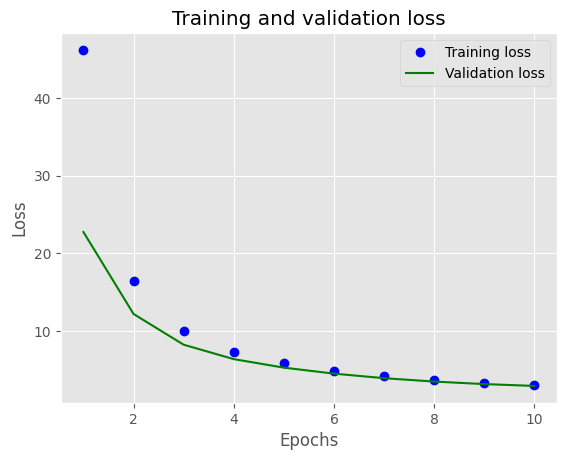

In [ ]:
plt.clf()
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy plot for training and validation datasets

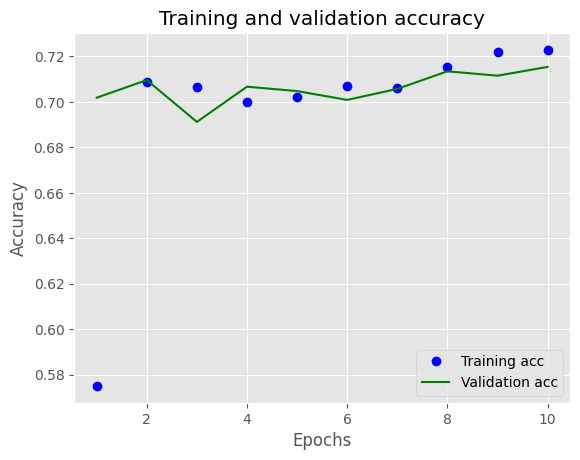

In [ ]:
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Model evaluation

In [ ]:
results = model.evaluate(x_test, one_hot_test_labels)
print(f"Test loss {results[0]:.4f}, test accuracy {results[1]:.4f} ")

71/71 [==============================] - 0s 6ms/step - loss: 3.0149 - accuracy: 0.7057
Test loss 3.0149, test accuracy 0.7057 


# Manual prediction inspection

In [ ]:
predictions = model.predict(x_test)
# Each entry in predictions is a vector of length 46
print(predictions[123].shape)

# The coefficients in this vector sum to 1:
print(np.sum(predictions[123]))

# The largest entry is the predicted class — the class with the highest probability:
print(np.argmax(predictions[123]))

71/71 [==============================] - 0s 4ms/step
(46,)
0.9999999
4


In [ ]:
SampleNum = 2125

print(decoded_news(SampleNum),"\n", test_labels[SampleNum], decoded_labels[test_labels[SampleNum]])
print(predictions[SampleNum].argsort()[-3:][::-1])  # Get the top 3 classes

test_labels[SampleNum] in predictions[SampleNum].argsort()[-3:][::-1] # check if test label is in predicted labels

? shr two cts vs one ct net 42 000 vs 26 000 sales 15 6 mln vs 15 2 mln note 1987 net includes gain 63 000 dlrs from change in pension accounting reuter 3 
 6 copper
[ 4  3 19]


False

In [ ]:
# Create a top 3 matrix

Top3Preds = np.zeros((2246,3), dtype=int)
print(Top3Preds.shape)

for SampleNum in range(predictions.shape[0]):
    Top3Preds[SampleNum] = predictions[SampleNum].argsort()[-3:][::-1]

Top3Preds

(2246, 3)


array([[ 3,  4, 16],
       [ 1, 10,  2],
       [ 1, 13, 10],
       ...,
       [ 3,  4, 20],
       [ 3,  4, 16],
       [ 1, 13, 10]])

In [ ]:
# Modify the raw final_predictions - prediction probs into 0 and 1 for the confusion matrix

FinalPreds = np.zeros((2246,1), dtype=int)
print(FinalPreds.shape)

for SampleNum in range(Top3Preds.shape[0]):
    if test_labels[SampleNum] in Top3Preds[SampleNum]:
        FinalPreds[SampleNum] = 1

FinalPreds

(2246, 1)


array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [ ]:
FinalPreds = pd.DataFrame(FinalPreds)
NumTop3 = FinalPreds[0][FinalPreds[0] == 1].count()
percentTop3 = round(100 *NumTop3 / FinalPreds.shape[0], 1)

print('Percent of one from top 3 being correct ... ', percentTop3, '%')

Percent of one from top 3 being correct ...  80.5 %


In [ ]:
gc.collect()

18631